In [52]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from prediction_helpers import *

In [53]:
ExE = pd.read_csv('extracted_data/ExE_imputed_5.csv', sep=',', index_col=0)
NxN = pd.read_csv('extracted_data/NxN_imputed_10.csv', sep=',', index_col=0)
ExN = pd.read_csv('extracted_data/ExN_filled_20.csv', sep=',', index_col=0)

In [54]:
pca_linear_regression = Pipeline([
    ('pca', PCA(n_components=0.9)), 
    ('linear_regression', LinearRegression())
])
pca_linear_regression.name = 'PCA + Linear Regression'

predictive_models_ExE = [ 
    pca_linear_regression,
    Lasso(alpha=0.0001),
    Ridge(alpha=5),
    RandomForestRegressor(n_estimators=10, random_state=42)
]

predictive_models_NxN = [ 
    pca_linear_regression,
    Lasso(alpha=0.00005),
    Ridge(alpha=10),
    RandomForestRegressor(n_estimators=10, random_state=42)
]

predictive_models_ExN = [ 
    pca_linear_regression,
    Lasso(alpha=0.00005),
    Ridge(alpha=5),
    RandomForestRegressor(n_estimators=10, random_state=42)
]

random.seed(35)
proportion = 0.01

## ExE


Model: Pipeline
Average R²:   0.3409
Average RMSE: 0.0556

Model: Lasso
Average R²:   0.3893
Average RMSE: 0.0531

Model: Ridge
Average R²:   0.3986
Average RMSE: 0.0534

Model: RandomForestRegressor
Average R²:   0.3043
Average RMSE: 0.0578


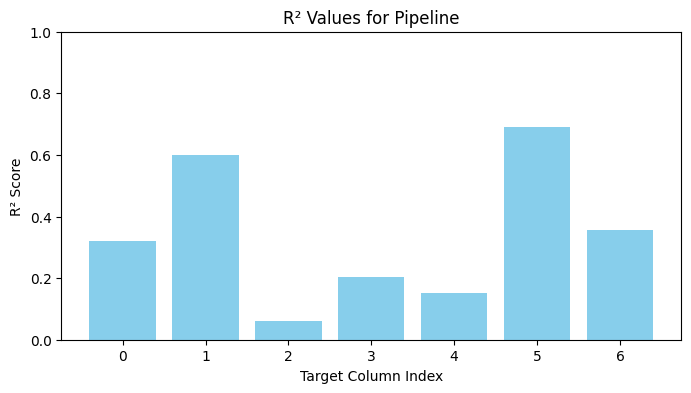

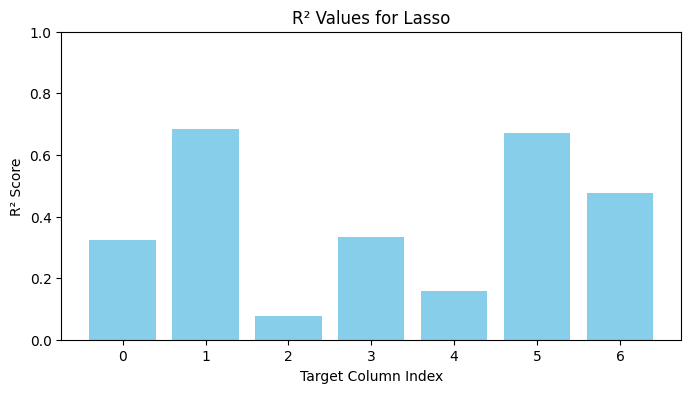

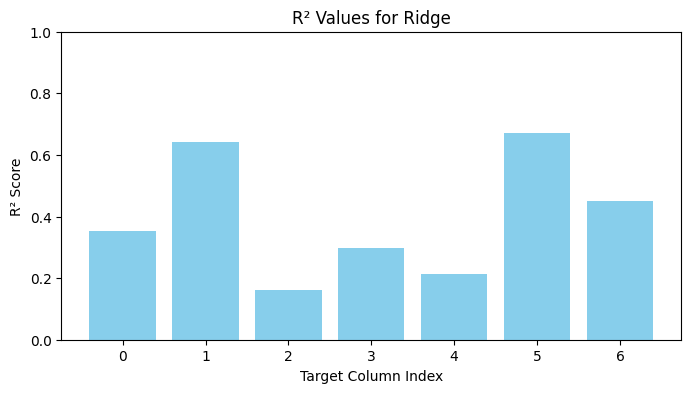

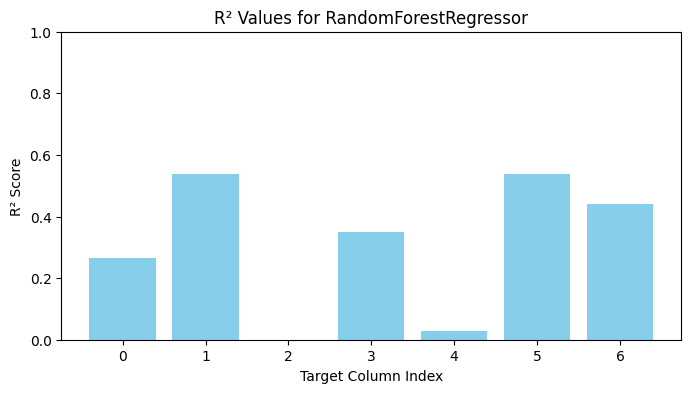

In [55]:
results_ExE = iterate_over_proportion(ExE, proportion, predictive_models_ExE)
print_results(results_ExE)
plot_results(results_ExE)

## NxN

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Model: Pipeline
Average R²:   0.1118
Average RMSE: 0.0378

Model: Lasso
Average R²:   0.2507
Average RMSE: 0.0344

Model: Ridge
Average R²:   0.2386
Average RMSE: 0.0353

Model: RandomForestRegressor
Average R²:   0.0351
Average RMSE: 0.0404


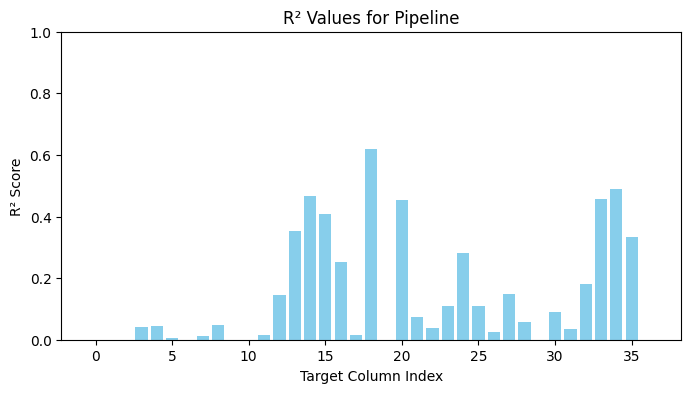

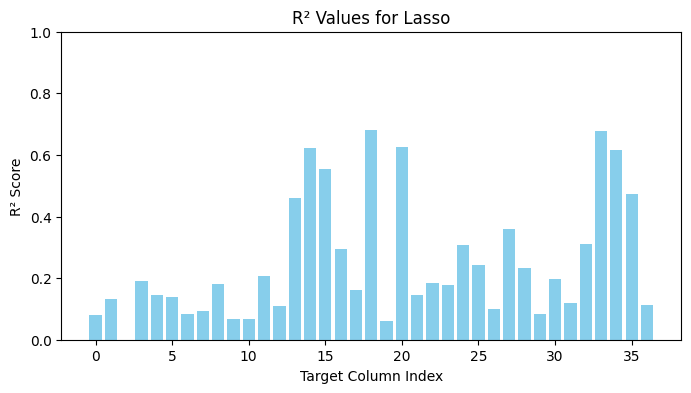

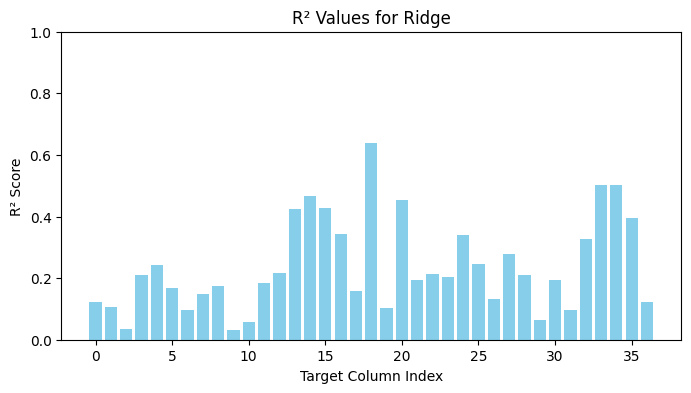

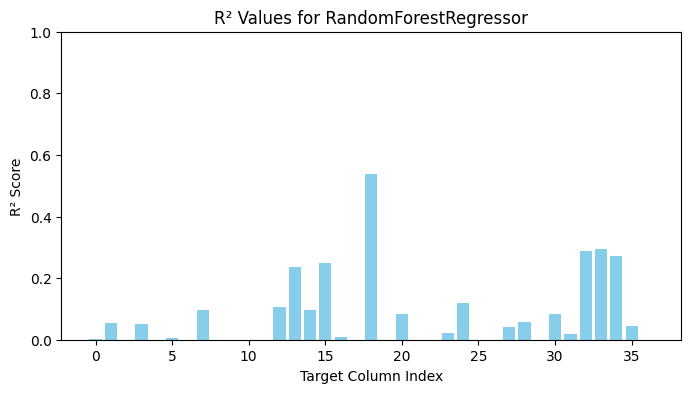

In [56]:
results_NxN = iterate_over_proportion(NxN, proportion, predictive_models_NxN)
print_results(results_NxN)
plot_results(results_NxN)

## ExN


Model: Pipeline
Average R²:   0.3409
Average RMSE: 0.0556

Model: Lasso
Average R²:   0.3071
Average RMSE: 0.0568

Model: Ridge
Average R²:   0.3986
Average RMSE: 0.0534

Model: RandomForestRegressor
Average R²:   0.3043
Average RMSE: 0.0578


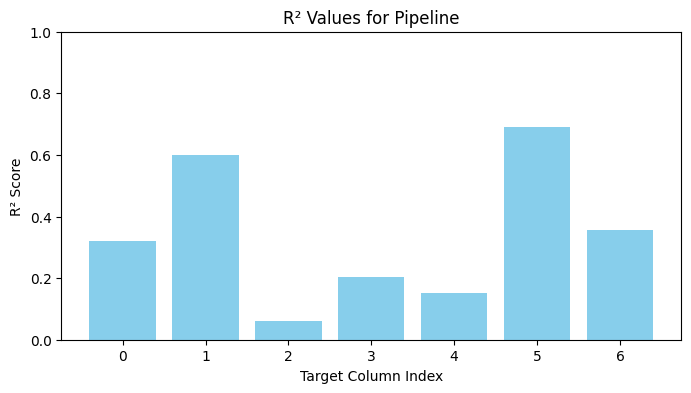

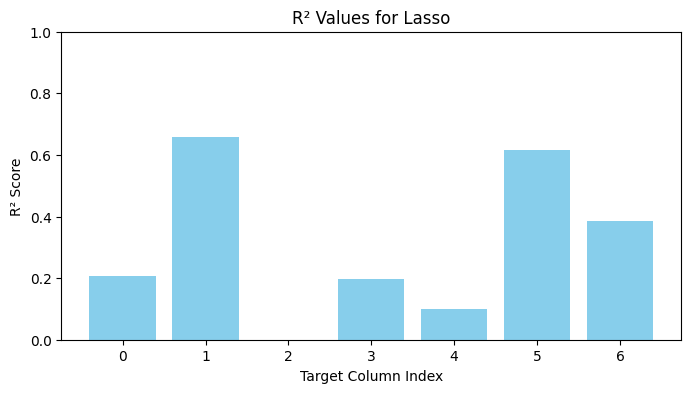

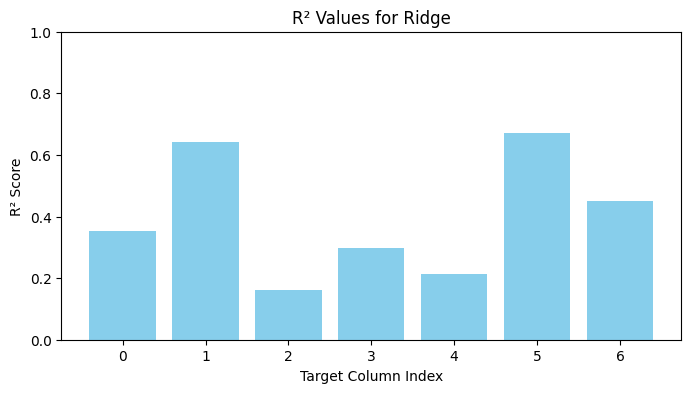

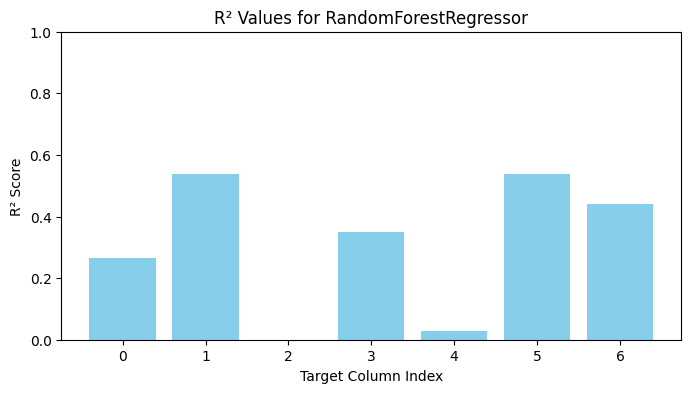

In [57]:
results_ExN = iterate_over_proportion(ExE, proportion, predictive_models_ExN)
print_results(results_ExN)
plot_results(results_ExN)


## Compilation Date

In [58]:
from datetime import datetime

now = datetime.now()
print(now.strftime("%Y-%m-%d %H:%M:%S"))

2025-03-27 14:22:38
